# Example OI SSH mapping and eSQG vertical reconstruction 
## from 4 nadirs in GULFSTREAM region

In [1]:
import numpy as np
import pylab as plt
import sys, os 
import xarray as xr 
import warnings 
warnings.filterwarnings('ignore')

In [8]:
import or3d.class_ssh_mapping as sm
import or3d.class_vertical_reconstruction as vr

## 1. Set grid, OI and observation parameters

In [3]:
# OI Grid
lon_min = -65.                                           # domain min longitude
lon_max = -55.                                           # domain max longitude
lat_min = 33.                                            # domain min latitude
lat_max = 43.                                            # domain max latitude
time_min = np.datetime64('2012-10-22')                   # domain min time
time_max = np.datetime64('2012-12-02')                   # domain max time
dx = 0.2                                                 # zonal grid spatial step (in degree)
dy = 0.2                                                 # meridional grid spatial step (in degree)
dt = np.timedelta64(1, 'D')                              # temporal grid step

simu_start_date = '2012-10-01T00:00:00'                  # Nature run initial date

glon = np.arange(lon_min, lon_max + dx, dx)              # output OI longitude grid
glat = np.arange(lat_min, lat_max + dy, dy)              # output OI latitude grid
gtime = np.arange(time_min, time_max + dt, dt)           # output OI time grid

# OI parameters
Lx = 1.                                                  # Zonal decorrelation scale (in degree)
Ly = 1.                                                  # Meridional decorrelation scale (in degree)
Lt = 7.                                                  # Temporal decorrelation scale (in days)
noise = 0.05                                             # Noise level (5%)

# Observation paths
obs_inputs = ['../data/SSH_obs/2020a_SSH_mapping_NATL60_jason1.nc','../data/SSH_obs/2020a_SSH_mapping_NATL60_envisat.nc','../data/SSH_obs/2020a_SSH_mapping_NATL60_geosat2.nc','../data/SSH_obs/2020a_SSH_mapping_NATL60_topex-poseidon_interleaved.nc'] 

# Output paths
output_oi = f'../data/SSH_fields/ssh_reconstruction_'+str(time_min)+'-'+str(time_max)+'_4nadirs.nc'

## 2. Create an ssh mapping instance

In [4]:
my_oi_mapping = sm.ssh_mapping(
    obs_in = obs_inputs,
    output = output_oi,
    lonlat_minmax = [lon_min,lon_max,lat_min,lat_max],
    time_minmax = [time_min,time_max],
    dx = dx,
    dy = dy,
    dt = dt,
    simu_start_date = simu_start_date
) 

## 4. Run the OI mapping 

In [5]:
my_oi_mapping.run_oi(Lx=Lx,Ly=Ly,Lt=Lt,noise=noise)

## 5. Retrieve and plot the SSH mapping

In [6]:
with xr.open_dataset(output_oi, mask_and_scale=True) as (ds_2):   
        ssh = np.zeros_like(ds_2.gssh)  
        ssh[:,:,:] = ds_2.gssh[:,:,:] 
        lon = np.zeros_like(ds_2.glon2)
        lon[:,:] = ds_2.glon2 
        lat = np.zeros_like(ds_2.glat2)
        lat[:,:] = ds_2.glat2
ssh = np.ma.masked_invalid(ssh)

Text(0.5,1,'Last day')

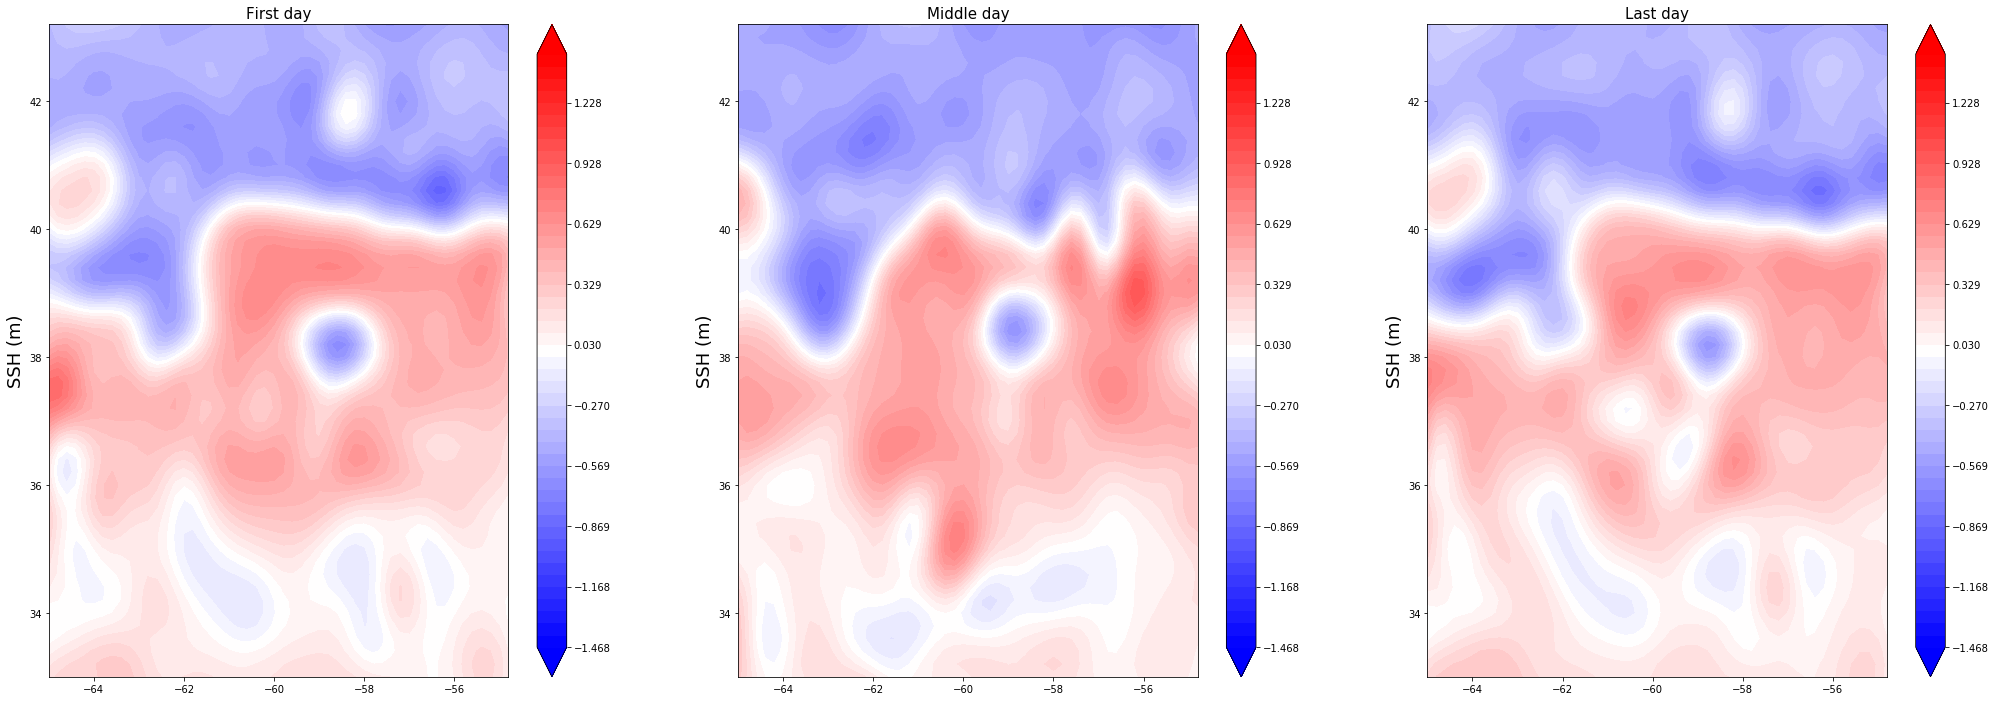

In [7]:
max_var = np.max(np.abs(ssh))
levs = np.linspace(-max_var,max_var, 50)
plt.figure(figsize=(35,12))
plt.subplot(131)
plt.contourf(lon,lat,ssh[0,:,:]-np.mean(ssh[0,:,:]),cmap=plt.cm.get_cmap('bwr'),levels=levs,extend='both')
plt.colorbar() 
plt.ylabel('SSH (m)',fontsize=18)
plt.title('First day',fontsize=15)

plt.subplot(132)
plt.contourf(lon,lat,ssh[int(np.shape(ssh)[0]/2),:,:]-np.mean(ssh[int(np.shape(ssh)[0]/2),:,:]),cmap=plt.cm.get_cmap('bwr'),levels=levs,extend='both')
plt.colorbar() 
plt.ylabel('SSH (m)',fontsize=18)
plt.title('Middle day',fontsize=15)

plt.subplot(133)
plt.contourf(lon,lat,ssh[2,:,:]-np.mean(ssh[2,:,:]),cmap=plt.cm.get_cmap('bwr'),levels=levs,extend='both')
plt.colorbar() 
plt.ylabel('SSH (m)',fontsize=18)
plt.title('Last day',fontsize=15)
 

## 6. Create an ocean reconstruction instance

In [26]:
my_esqg_reconstruction = vr.vertical_reconstruction()

## 7. Enter reconstruction parameters

In [27]:
my_esqg_reconstruction.ssh = ssh[int(np.shape(ssh)[0]/2),:,:] 
my_esqg_reconstruction.lon = lon
my_esqg_reconstruction.lat = lat 
depth = - np.arange(0,1000,10) 
my_esqg_reconstruction.z = depth
my_esqg_reconstruction.N0 = 2*2*np.pi/86164*np.sin(lat*np.pi/180)                                    
my_esqg_reconstruction.C = 2.6                                            
my_esqg_reconstruction.sppad = 3
my_esqg_reconstruction.corrN = np.ones_like(depth)
my_esqg_reconstruction.periodsmooth = 1

## 8. Run the eSQG reconstruction 

In [28]:
my_esqg_reconstruction.run_esqg()

## 9. Plot the reconstructed variables

Plotting surface variable
SSD anomaly is not available for plotting
SST anomaly is not available for plotting
Plotting 3D variables


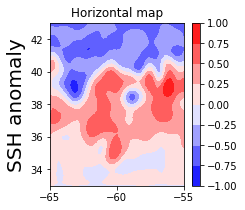

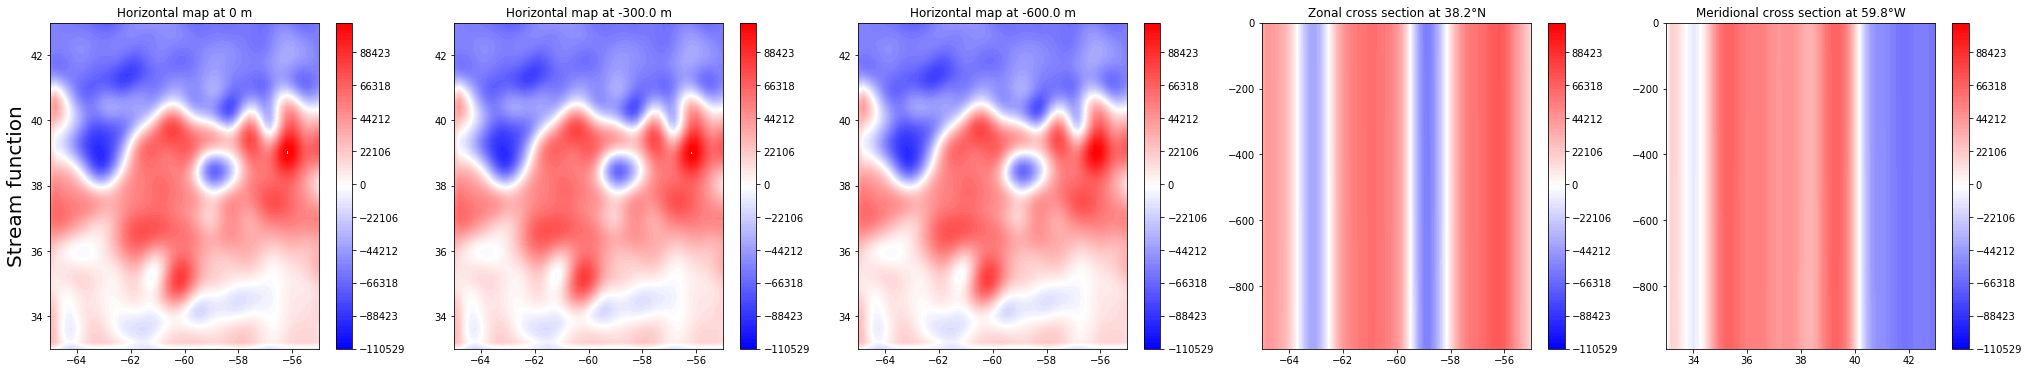

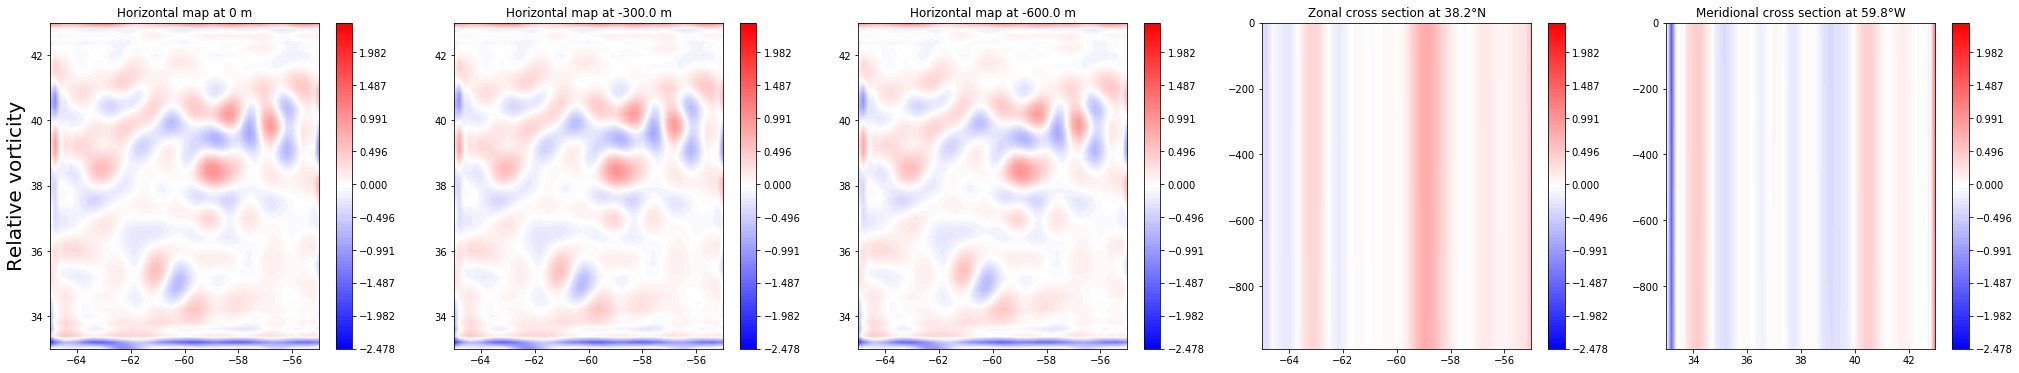

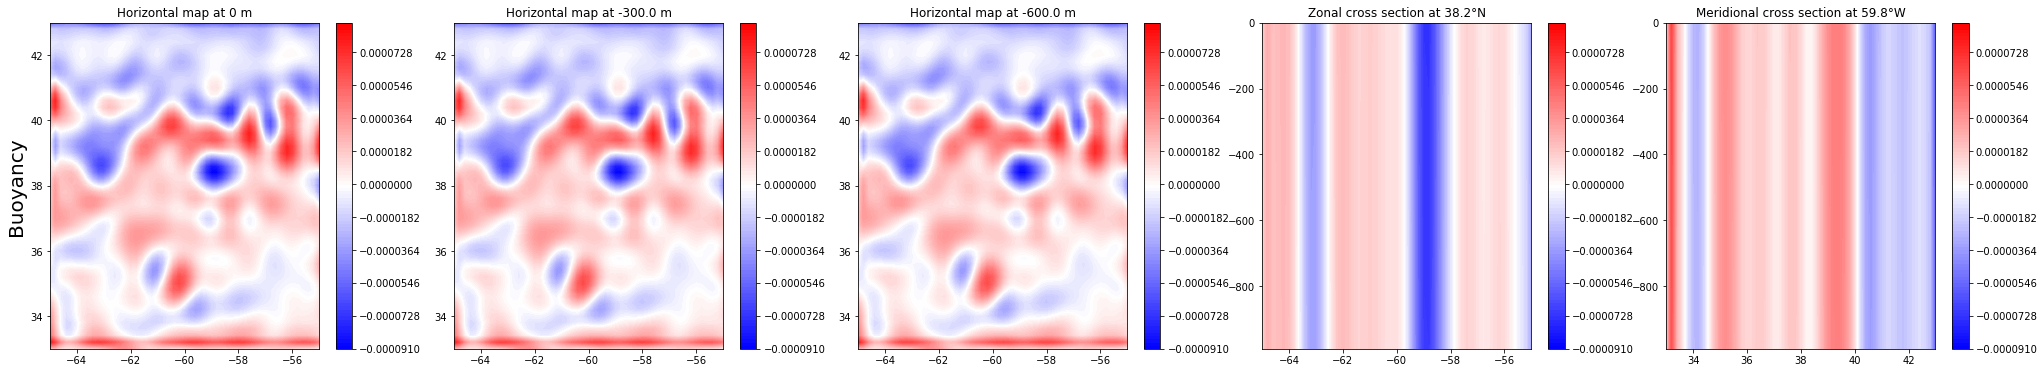

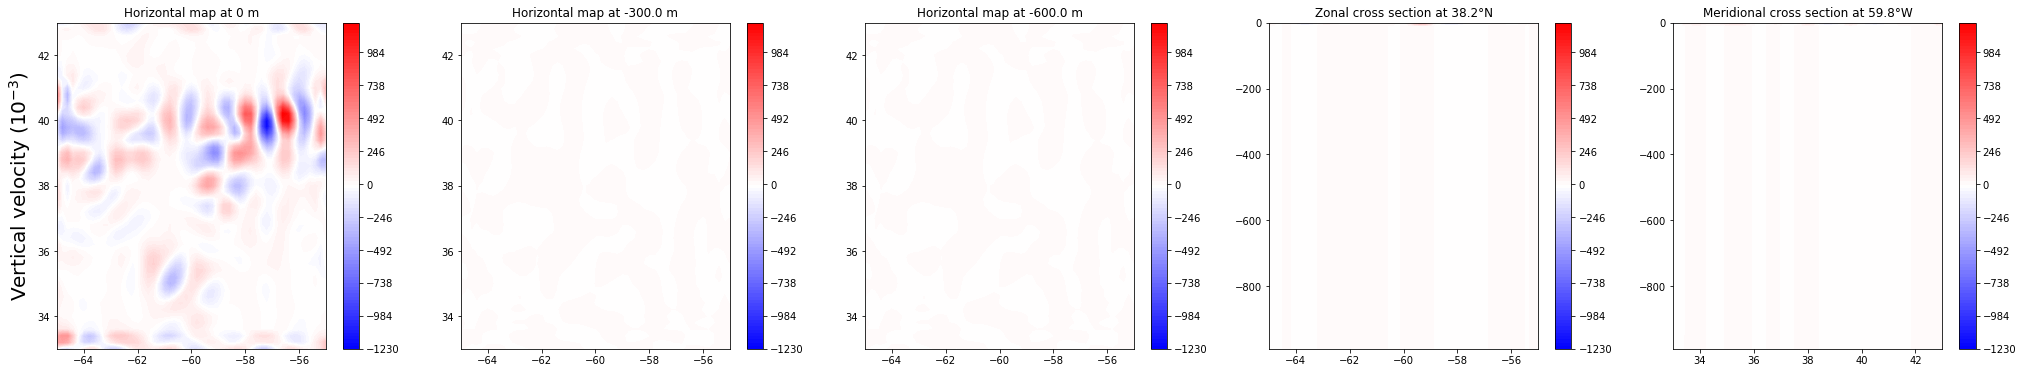

In [29]:
my_esqg_reconstruction.plot_reconstruction_outputs()